In [1]:
import os
dataset = 'ChildData/OUTPUTFOLDER/Train'
print(os.listdir(dataset))

classes = [folder for folder in os.listdir(dataset) if os.path.isdir(os.path.join(dataset, folder))]
count = []

for folder in classes:
    folder_path = os.path.join(dataset, folder)
    num_image = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    count.append(num_image)
    print(f"{folder} = {num_image}")

['Fear', 'Sad', 'Angry', 'Neutral', 'Surprised', 'Happiness', 'Disgust']
Fear = 5
Sad = 21
Angry = 6
Neutral = 22
Surprised = 10
Happiness = 26
Disgust = 11


In [2]:
dataset = 'ChildData/OUTPUTFOLDER/Test/'
print(os.listdir(dataset))

classes = [folder for folder in os.listdir(dataset) if os.path.isdir(os.path.join(dataset, folder))]
count = []

for folder in classes:
    folder_path = os.path.join(dataset, folder)
    num_image = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    count.append(num_image)
    print(f"{folder} = {num_image}")

['Fear', 'Sad', 'Angry', 'Neutral', 'Surprised', 'Happiness', 'Disgust']
Fear = 2
Sad = 6
Angry = 2
Neutral = 6
Surprised = 3
Happiness = 7
Disgust = 3


In [3]:
import os
import glob
import torch
import torch.nn as nn
import torchvision.transforms as tt
import torchvision
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
import pathlib
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

2025-02-08 11:19:19.268689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-08 11:19:19.390691: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-08 11:19:19.432738: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-08 11:19:19.628755: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-08 11:19:22.215580: W tensorflow/compiler/tf2

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
class CustomDataset(Dataset):
    def __init__(self, data_path, transform=None):
        """
        Args:
            data_path (str): Path to the dataset (train or test).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_path = data_path
        self.transform = transform

        # Get all class subfolders (e.g., 'Angry', 'Disgust', etc.)
        self.class_names = sorted(os.listdir(data_path))  # Assumes class names are folder names
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.class_names)}

        # Get image file paths along with corresponding labels
        self.image_paths = []
        self.labels = []

        for class_name in self.class_names:
            class_folder = os.path.join(data_path, class_name)
            if os.path.isdir(class_folder):
                for fname in os.listdir(class_folder):
                    if fname.endswith('.jpg'):
                        self.image_paths.append(os.path.join(class_folder, fname))
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        # Return the number of images in the dataset
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load an image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        # Get the label (index of the class)
        label = self.labels[idx]

        # Apply the transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label

In [179]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.7),  # 70% chance of horizontal flip
    transforms.RandomVerticalFlip(p=0.3),  # 30% chance of vertical flip
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [180]:
train_path = 'ChildData/OUTPUTFOLDER/Train/'
test_path = 'ChildData/OUTPUTFOLDER/Test/'

In [181]:
train_dataset = CustomDataset(data_path=train_path, transform=transform)
test_dataset = CustomDataset(data_path=test_path, transform=transform)

torch.Size([3, 224, 224])


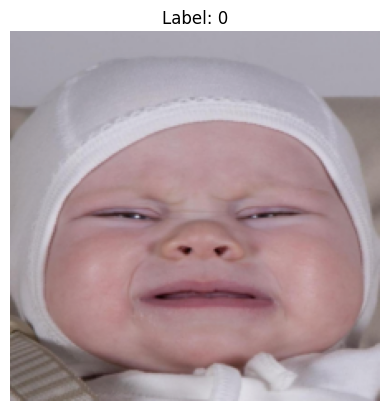

In [182]:
image_tensor, label = train_dataset[0][0].shape, train_dataset[0][1]

import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

# Assuming train_dataset[0][0] is the image tensor
image_tensor = train_dataset[0][0]  # Get the first image tensor from the dataset
label = train_dataset[0][1]  # Get the label for the first image

# Check the shape of the tensor to make sure it's [C, H, W]
print(image_tensor.shape)

# If your transform used normalization, reverse it like this:
mean = [0.485, 0.456, 0.406]  # Example for ImageNet
std = [0.229, 0.224, 0.225]

# Reverse the normalization
denormalize = transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])
image_tensor = denormalize(image_tensor)

# Convert the tensor to a PIL Image
to_pil = ToPILImage()
image = to_pil(image_tensor)

# Display the image using matplotlib
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')  # Hide axes for clarity
plt.show()

In [226]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [227]:
# Load MobileNetV2 model pre-trained on ImageNet
model = models.mobilenet_v2(pretrained=True)

In [228]:
# Modify the classifier for our task (number of classes in your dataset)
num_classes = len(train_dataset.class_names)  # Number of classes in your dataset
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

In [229]:
for param in model.parameters():
    param.requires_grad = False

In [230]:
for param in model.classifier[1].parameters():
    param.requires_grad = True

In [231]:
for param in model.features[18].parameters():
    param.requires_grad = True

for param in model.features[17].parameters():
    param.requires_grad = True

# for param in model.features[16].parameters():
#     param.requires_grad = True

In [232]:
for name, param in model.named_parameters():
    print(f'{name}: {param.requires_grad}')

features.0.0.weight: False
features.0.1.weight: False
features.0.1.bias: False
features.1.conv.0.0.weight: False
features.1.conv.0.1.weight: False
features.1.conv.0.1.bias: False
features.1.conv.1.weight: False
features.1.conv.2.weight: False
features.1.conv.2.bias: False
features.2.conv.0.0.weight: False
features.2.conv.0.1.weight: False
features.2.conv.0.1.bias: False
features.2.conv.1.0.weight: False
features.2.conv.1.1.weight: False
features.2.conv.1.1.bias: False
features.2.conv.2.weight: False
features.2.conv.3.weight: False
features.2.conv.3.bias: False
features.3.conv.0.0.weight: False
features.3.conv.0.1.weight: False
features.3.conv.0.1.bias: False
features.3.conv.1.0.weight: False
features.3.conv.1.1.weight: False
features.3.conv.1.1.bias: False
features.3.conv.2.weight: False
features.3.conv.3.weight: False
features.3.conv.3.bias: False
features.4.conv.0.0.weight: False
features.4.conv.0.1.weight: False
features.4.conv.0.1.bias: False
features.4.conv.1.0.weight: False
featu

In [233]:
# Move model to GPU if available
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [234]:
device

device(type='cuda', index=1)

In [235]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.padding_idx = -1

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        nll_loss = -pred.gather(dim=-1, index=target.unsqueeze(-1))
        nll_loss = nll_loss.squeeze(-1)

        # Apply label smoothing
        nll_loss = nll_loss * self.confidence + (1.0 - nll_loss) * self.smoothing
        return nll_loss.mean()

# Using CrossEntropyLoss with label smoothing
criterion = LabelSmoothingLoss(classes=num_classes, smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [236]:
# Set up TensorBoard writer
writer = SummaryWriter()

In [237]:
# Training and testing loop
epochs = 40
train_losses = []
test_losses = []

def train_one_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    return epoch_loss, accuracy

In [238]:

def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total

    return epoch_loss, accuracy, all_preds, all_labels

In [ ]:
# Training loop
for epoch in range(epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_accuracy, all_preds, all_labels = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # Log to TensorBoard
    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Loss/Test', test_loss, epoch)
    writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
    writer.add_scalar('Accuracy/Test', test_accuracy, epoch)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Epoch [{epoch+1}/{epochs}], Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch [1/40], Train Loss: 1.7600, Train Accuracy: 10.89%
Epoch [1/40], Test Loss: 1.7474, Test Accuracy: 24.14%
Epoch [2/40], Train Loss: 1.5552, Train Accuracy: 23.76%
Epoch [2/40], Test Loss: 1.6445, Test Accuracy: 20.69%
Epoch [3/40], Train Loss: 1.3906, Train Accuracy: 49.50%
Epoch [3/40], Test Loss: 1.5927, Test Accuracy: 13.79%
Epoch [4/40], Train Loss: 1.2731, Train Accuracy: 67.33%
Epoch [4/40], Test Loss: 1.5058, Test Accuracy: 20.69%
Epoch [5/40], Train Loss: 1.1450, Train Accuracy: 59.41%
Epoch [5/40], Test Loss: 1.5149, Test Accuracy: 24.14%
Epoch [6/40], Train Loss: 1.0747, Train Accuracy: 62.38%
Epoch [6/40], Test Loss: 1.6028, Test Accuracy: 17.24%


In [ ]:
# Plot loss curves
plt.figure(figsize=(10,5))
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Losses')
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [198]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt
from PIL import Image

# Custom dataset (same as the one you provided earlier)
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.class_names = sorted(os.listdir(data_path)) 
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.class_names)}
        self.image_paths = []
        self.labels = []

        for class_name in self.class_names:
            class_folder = os.path.join(data_path, class_name)
            if os.path.isdir(class_folder):
                for fname in os.listdir(class_folder):
                    if fname.endswith('.jpg'):
                        self.image_paths.append(os.path.join(class_folder, fname))
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Data preprocessing with transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (MobileNetV2 expects this size)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_path = 'ChildData/OUTPUTFOLDER/Train/'
test_path = 'ChildData/OUTPUTFOLDER/Test/'

train_dataset = CustomDataset(data_path=train_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load the pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Freeze all layers except the last one (classifier)
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify the classifier to fit the number of classes in our dataset
num_classes = len(train_dataset.class_names)  # Number of classes in the dataset
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Unfreeze the last layer (classifier) for training
for param in model.classifier[1].parameters():
    param.requires_grad = True  # Unfreeze the last fully connected layer

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop variables
epochs = 100
train_losses = []

# Training loop
def train_one_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    return epoch_loss, accuracy

# Training loop for multiple epochs
for epoch in range(epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

# Save the trained model to a file
torch.save(model.state_dict(), 'mobilenetv2_finetuned.pth')
print("Model saved to 'mobilenetv2_finetuned.pth'")

# Plot the training loss curve
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curve')
plt.show()


/raid/home/dgx1575/20je0167_anurag/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/raid/home/dgx1575/20je0167_anurag/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: CUDA error: CUBLAS_STATUS_NOT_INITIALIZED when calling `cublasCreate(handle)`

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from PIL import Image
import os
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset

# Custom Dataset (same as before)
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.class_names = sorted(os.listdir(data_path)) 
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.class_names)}
        self.image_paths = []
        self.labels = []

        for class_name in self.class_names:
            class_folder = os.path.join(data_path, class_name)
            if os.path.isdir(class_folder):
                for fname in os.listdir(class_folder):
                    if fname.endswith('.jpg'):
                        self.image_paths.append(os.path.join(class_folder, fname))
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Data preprocessing with transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fit MobileNetV2 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_path = 'ChildData/OUTPUTFOLDER/Test/'  # Path to your test data
test_dataset = CustomDataset(data_path=test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.mobilenet_v2(pretrained=False)  # Load the base model
num_classes = len(test_dataset.class_names)

# Modify the classifier to fit the number of classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load('mobilenetv2_finetuned.pth'))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Loss function for testing
criterion = nn.CrossEntropyLoss()

# Function to calculate accuracy and loss during testing
def evaluate_model(model, data_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to track gradients during evaluation
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())  # Store predictions for confusion matrix
            all_labels.extend(labels.cpu().numpy())  # Store true labels

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(data_loader)
    return accuracy, avg_loss, all_preds, all_labels

# Evaluate the model on the test dataset
test_accuracy, test_loss, test_preds, test_labels = evaluate_model(model, test_loader, criterion, device)

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Plot the testing loss curve
# Here, we assume the testing loss is accumulated over all batches, so we can plot it once.
# If you want to plot for each batch, you can store and plot that too.

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Optionally, you could also plot the loss per batch if you store them during testing
